In [1]:
import csv
import os

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
labels = pd.read_csv('public/y_train.csv', index_col='id')

In [3]:
# Retrieve one sample recording per class for plotting
labels_array = labels['y'].to_numpy()
num_classes = 4
sample_signal_ids = []
for class_id in range(num_classes):
    sample_signal_ids.append(int(np.argwhere(labels_array == class_id)[0]))
    
# Print indices of the sample signals
sample_signal_ids

[0, 3, 4, 30]

In [4]:
data = pd.read_csv('public/X_train.csv', index_col='id')

In [5]:
# Show the data
data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
id,,,,,,,,,,,,,,,,,,,,,
0,-64,-66,-69,-72,-75,-77,-80,-86,-89,-83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,505,500,496,492,487,480,475,476,483,495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-21,-16,-12,-7,-3,0,1,2,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-211,-457,-635,-710,-715,-663,-573,-481,-401,-337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36,32,29,25,22,19,17,15,12,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,-285,-303,-334,-376,-413,-432,-443,-451,-460,-468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5113,50,51,50,48,46,44,42,39,36,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5114,-207,-225,-242,-258,-266,-271,-275,-279,-281,-284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pay attention to NaN values! 

Unlike many medical application, these NaNs **DO NOT** represent missing values but appear because of variable length of the signals. ECG recordings normally don't have missing values and are sampled equally.

Despite being put into a tabular CSV format / Pandas Dataframe, the data is still a raw signal with variable lengths. Coumns *x0, ..., x17841* correspond to measurements at time stamps *0, ..., 17841* and not to different features of the data point. If the signal is too short then all the coumns after the last measurement have NaN values,

In [6]:
# Get the raw recording without Nan values as a NumPy array
data.loc[0].dropna().to_numpy(dtype='float32')

array([-64., -66., -69., ..., -43., -35., -25.], dtype=float32)

## Plot sample signals for each class

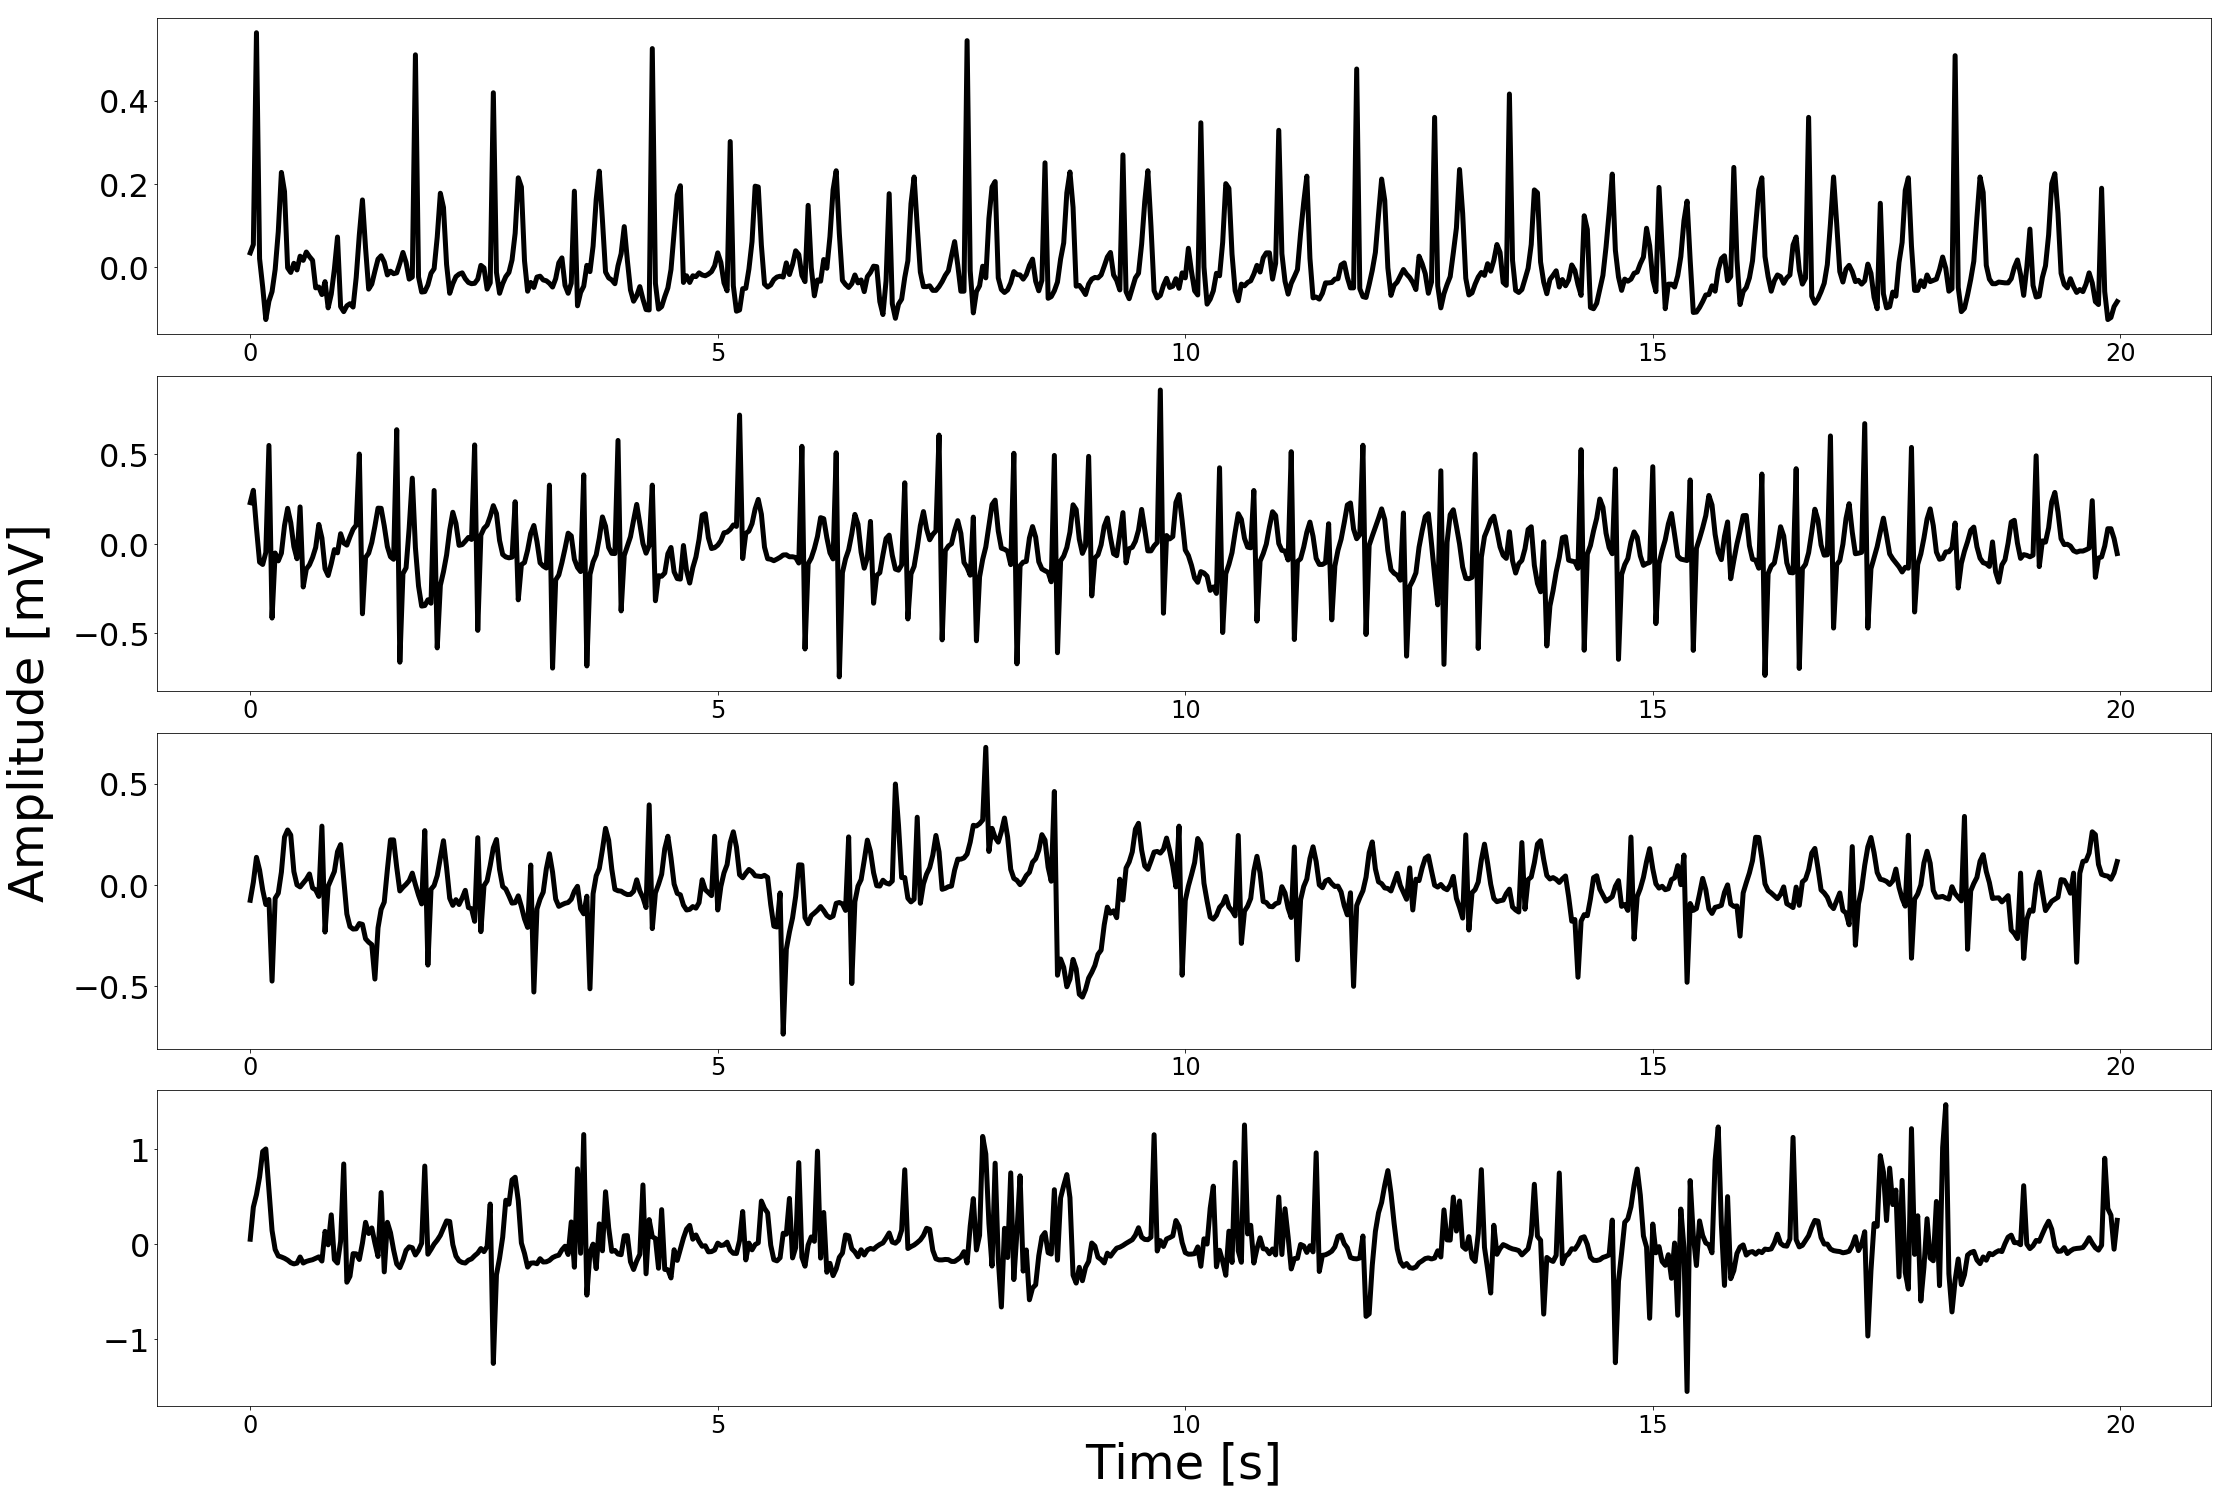

In [7]:
# Some matplotlib setting 
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 32
plt.rcParams['axes.labelsize'] = 48
plt.rcParams['axes.titlesize'] = 48

fig, axs = plt.subplots(4, 1)

seconds = np.arange(0, 600) / 30 
x_labels = [0, 5, 10, 15, 20]

for class_id in range(num_classes):
    ax = axs[class_id]
    #ax.set_title("Class {}".format(class_id))
    
    measurements = data.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32')
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements[1000:7000:10] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k')
    ax.set_xticks(x_labels)
          
fig.tight_layout()

# Display x- and y-labels for the whole plot
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.yaxis.set_label_coords(-0.05, 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')            
plt.show()

In [8]:
def plot_features(signal):
    r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
    #print(r_peaks)
    if len(r_peaks) >= 2:
        #print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)
            
            plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')
            # Fill the variance range
            plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
            # Plot a median
            plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')

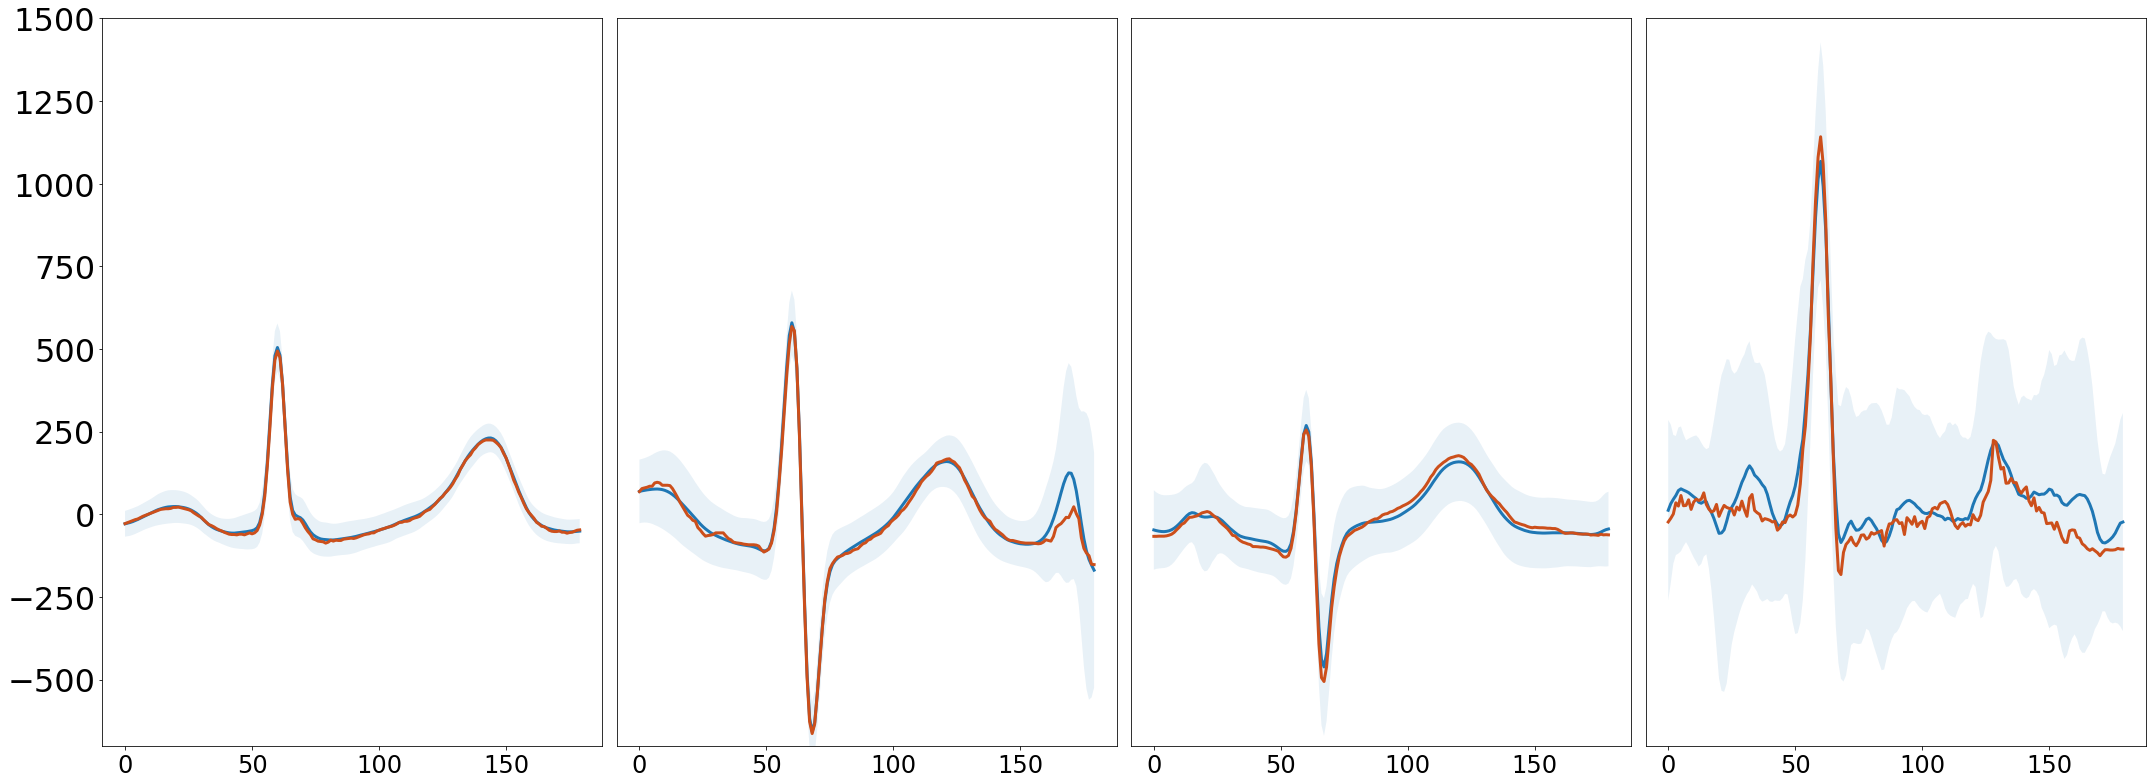

In [9]:
plt.rcParams['lines.linewidth'] = 3
plt.figure(figsize=(30, 11))
for class_id in range(num_classes):
    ax = plt.subplot(1, 4, class_id + 1)
    #ax.set_title("Class {}".format(class_id))
    ax.set_ylim([-700, 1500])
    if class_id:
        ax.set_yticks([])
    plot_features(data.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32'))

plt.tight_layout()
plt.show()